# 表面符号

このノートブックでは、5量子ビットの表面符号を用いて、誤りの検出が可能なことを確認します。  
ただし、ここで見せるサンプルでは誤りの検出のみで、誤りの訂正はできません。

---
# ライブラリのインポート

In [ ]:
%pip install qiskit==0.45.2 qiskit-aer==0.12.0
%pip install pylatexenc

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import pauli_error

# 表面符号

ここでは、5量子ビットに状態を符号化して、観測用の量子ビットを4つ用意し、誤りが発生しているかどうかを確認します。  
どれか1つの観測用のビットが反転していれば、誤りが発生していることがわかります。

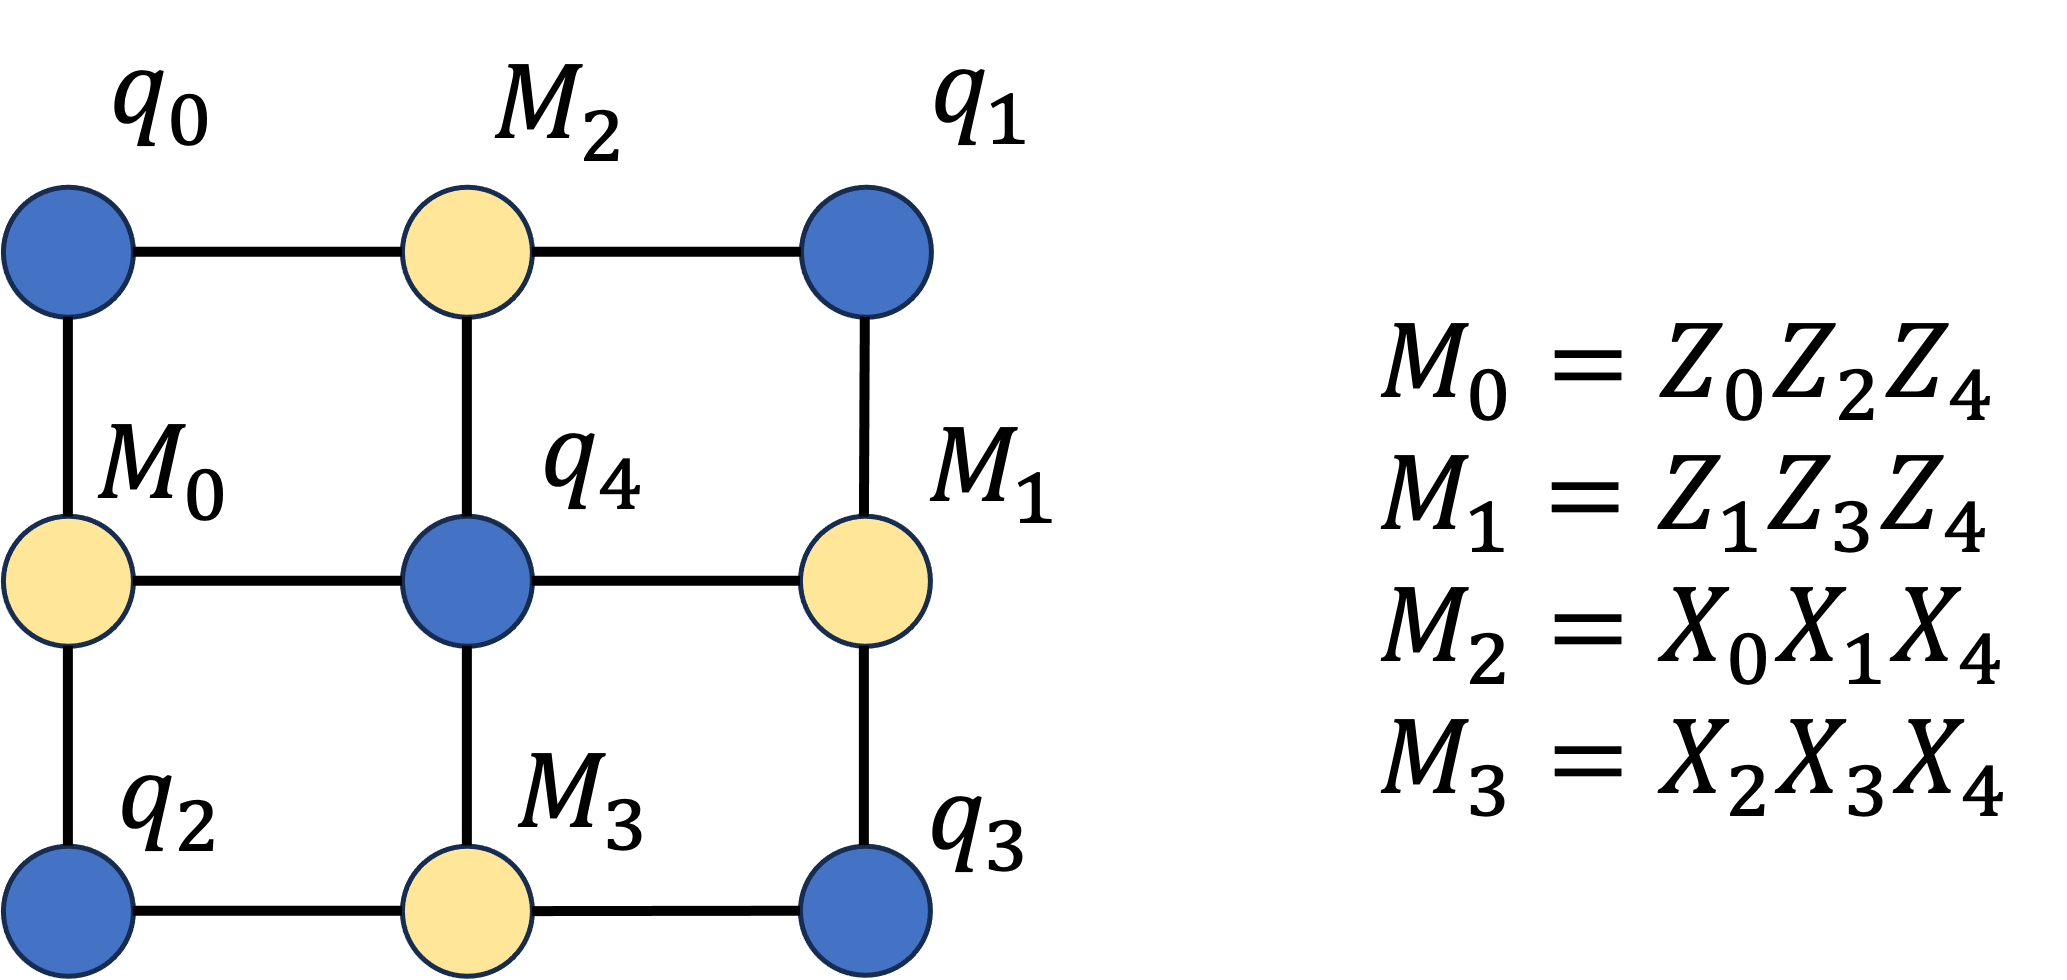

In [ ]:
def surface_code(bit_error_channel: list[int] = [], phase_error_channel: list[int] = []) -> QuantumCircuit:
    # bit_error_channel : ビット反転エラーを起こす量子ビット
    # phase_error_channel : 位相反転エラーを起こす量子ビット

    n_qubits = 5 + 4
    circ = QuantumCircuit(n_qubits, 4)

    # 符号化
    circ.h(7)
    circ.cx(7, 0)
    circ.cx(7, 1)
    circ.cx(7, 4)
    circ.cx(4, 7)


    circ.h(8)
    circ.cx(8, 2)
    circ.cx(8, 3)
    circ.cx(8, 4)
    circ.cx(3, 8)

    circ.barrier()

    # エラーが発生する部分
    for i in bit_error_channel:
        circ.x(i)

    for i in phase_error_channel:
        circ.z(i)

    circ.barrier()

    # エラー検知箇所
    # Z0 Z2 Z4
    circ.cx(0, 5)
    circ.cx(2, 5)
    circ.cx(4, 5)

    # Z1 Z3 Z4
    circ.cx(1, 6)
    circ.cx(3, 6)
    circ.cx(4, 6)

    # X0 X1 X4
    circ.h(7)
    circ.cx(7, 0)
    circ.cx(7, 1)
    circ.cx(7, 4)
    circ.h(7)

    # X2 X3 X4
    circ.h(8)
    circ.cx(8, 2)
    circ.cx(8, 3)
    circ.cx(8, 4)
    circ.h(8)

    circ.barrier()

    circ.measure([5, 6, 7, 8], [0, 1, 2, 3])

    return circ

In [ ]:
circ = surface_code()

In [ ]:
circ.draw("mpl")

In [ ]:
backend_sim = AerSimulator()
n_shots= 10000

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

すべての量子ビットが0になっています。

# エラー検出

次に、この回路にノイズを乗せてみます。  
ビット反転エラー、位相反転エラーによって、観測用ビットの値が変わることを確認します。

In [ ]:
circ = surface_code(bit_error_channel=[1])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

In [ ]:
circ = surface_code(phase_error_channel=[1])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

ただし、この方法では、以下のように、違う量子ビットにノイズを乗せても、同じ結果になってしまうことがあるため、エラー箇所の特定はできません。

In [ ]:
circ = surface_code(bit_error_channel=[3])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

In [ ]:
circ = surface_code(phase_error_channel=[0])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

また、2量子ビットのエラーでは検出できないことがあることを確認します。

In [ ]:
circ = surface_code(bit_error_channel=[0, 2])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))

0000となり、正常な状態と区別ができず、エラーが検出できません。  
ただし、2量子ビット以上でエラーが発生する全ての場合で検出できないわけではないです。

In [ ]:
circ = surface_code(bit_error_channel=[0, 1])

In [ ]:
result = backend_sim.run(circ, shots=n_shots).result()
plot_histogram(result.get_counts(0))